In [1]:
!pip install --force-reinstall -U bitsandbytes
!pip install --force-reinstall accelerate
!pip install --force-reinstall transformers datasets wget umap-learn
!pip install --force-reinstall info-nce-pytorch
!pip install --force-reinstall --upgrade soundfile

In [10]:
import math
import os
import json
import torch
import re
import requests
import torch.nn as nn
from PIL import Image
import wget
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import zipfile
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import requests
from transformers import LlavaProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
import time
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [11]:
# List to store the results
results = []
image_features, text_features= [], []

# define paths to the directories:
data_path = './numerosity_naming_images/'
image_list = os.listdir(data_path)

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing apples
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [data_path+f for f in image_list if category in f and f.endswith('.png')]
cat_target = ['There are ' + f.split('_')[0] + ' things' for f in apple_files]

# General target
targets = ['There are ' + f.split('_')[0] + ' things' for f in image_list if f.endswith('.png')]
print(len(targets))
print(len(cat_target))

2500
500


# BASELINE EVALUATION

### Load and prepare data

In [12]:
# List to store the results
results = []
image_features, image_features_proj, text_features, image_inputs, text_inputs = [], [], [], [], []
final_embeddings = []

# define paths to the directories:
data_path = './numerosity_naming_images/'
image_list = os.listdir(data_path)

categories = ['apples', 'butterflies', 'dots', 'people', 'fastcards']
n_categories = len(categories)

# Consider only the filenames containing apples
category = 'apples'
# Filter by 'apples' and '.png'
apple_files = [data_path+f for f in image_list if category in f and f.endswith('.png')]
targets = ['There are ' + f.split('_')[0] + ' things in this image' for f in image_list if f.endswith('.png')]
len(targets)

# Use a dictionary to store unique prefixes (e.g., '1_apples', '2_apples') with their full filenames
unique_apple_files = {}
for file in apple_files:
    prefix = '_'.join(file.split('_')[:2])  # Extract '1_apples', '2_apples'
    if prefix not in unique_apple_files:
        unique_apple_files[prefix] = file  # Store the full filename
    if len(unique_apple_files) == 20:  # Stop when we have 20 unique files
        break

len(image_list)

2500

In [5]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# define a seed for reproducibility
seed = 30
torch.manual_seed(seed)

# Updated categories
categories_test = ['dots', 'fastcards']  # Test categories become train
categories_train = ['butterflies', 'peoples', 'apples']  # Train categories become eval

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []


# Process images and compute features
for filename in tqdm(image_list):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)
    
    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(image_list):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(image_list)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Calculate the means of the embeddings
mean_image_embedding = np.mean(image_features, axis=0)  # Mean of all image embeddings
mean_text_embedding = np.mean(text_features, axis=0)    # Mean of all text embeddings

# Normalize the means
mean_image_embedding = mean_image_embedding / np.linalg.norm(mean_image_embedding)
mean_text_embedding = mean_text_embedding / np.linalg.norm(mean_text_embedding)

# Compute the gap (∆gap)
delta_gap = np.linalg.norm(mean_image_embedding - mean_text_embedding)

# Print the metric
#print(f"\nMean Image Embedding: {mean_image_embedding}")
#print(f"Mean Text Embedding: {mean_text_embedding}")
print(f"Delta Gap (∆gap): {delta_gap:.4f}")


100%|██████████| 2500/2500 [05:56<00:00,  7.01it/s]


Total Examples: 2500
Correct Predictions: 556
Misclassified Predictions: 1944
Accuracy: 0.2224

Cosine Similarity Statistics:
Correct Matches - Mean: 0.229, Min: 0.199, Max: 0.266
Misclassified Matches - Mean: 0.224, Min: 0.185, Max: 0.260

Euclidean Distance Statistics:
Correct Matches - Mean: 1.242, Min: 1.211, Max: 1.266
Misclassified Matches - Mean: 1.246, Min: 1.216, Max: 1.276

Correct Predictions by Target:
True Target
There are 1 things      44
There are 10 things      9
There are 2 things     109
There are 3 things     102
There are 4 things      25
There are 5 things      26
There are 6 things       2
There are 7 things       2
There are 8 things     123
There are 9 things     114
dtype: int64

Misclassified Predictions by Target:
True Target
There are 1 things     206
There are 10 things    241
There are 2 things     141
There are 3 things     148
There are 4 things     225
There are 5 things     224
There are 6 things     248
There are 7 things     248
There are 8 things   

# TRAIN TEMP 0.001

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# SEED
seed = 42
torch.manual_seed(seed)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.train().to(device)

# Split into training and testing sets (80/20 ratio)
image_train, image_test, target_train, target_test = train_test_split(
    image_list, targets, test_size=0.2, random_state=4, stratify=targets
)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor, data_path):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor
        self.data_path = data_path

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(os.path.join(self.data_path, image_path))  # Combine the data_path and image path
        caption = f'There are {self.targets[idx]} things'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]

# Function to create datasets
def create_datasets(image_train, target_train, image_test, target_test, data_path):
    # Create dataset instances
    train_dataset = CustomDataset(image_train, target_train, processor, data_path)
    test_dataset = CustomDataset(image_test, target_test, processor, data_path)
    
    return train_dataset, test_dataset

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_train, target_train, image_test, target_test, data_path)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=0.001)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

Epoch 1/10:  37%|███▋      | 23/63 [01:48<03:08,  4.72s/it, loss=2.71]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Loss values for each epoch
loss_values = [3.27, 2.92, 2.79, 2.74, 2.73, 2.71, 2.70, 2.69, 2.68, 2.68]

# Epochs
epochs = list(range(1, 11))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.ylim(0,3.50)
plt.grid(True)
plt.legend()
plt.show()


### Compute evaluation

In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []

# Process images and compute features
for filename in tqdm(image_list):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)

    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(image_list):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(apple_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results_temp0001.csv", sep=";", decimal=",", index=False)


### Compute image and text embeddings

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [02:23<00:00, 17.44it/s]


Total Examples: 500
Correct Predictions: 2287
Misclassified Predictions: 213
Accuracy: 4.5740

Cosine Similarity Statistics:
Correct Matches - Mean: 0.265, Min: 0.186, Max: 0.313
Misclassified Matches - Mean: 0.273, Min: 0.179, Max: 0.309

Euclidean Distance Statistics:
Correct Matches - Mean: 1.212, Min: 1.172, Max: 1.276
Misclassified Matches - Mean: 1.206, Min: 1.176, Max: 1.282

Correct Predictions by Target:
True Target
There are 1 things     247
There are 10 things    210
There are 2 things     250
There are 3 things     244
There are 4 things     240
There are 5 things     217
There are 6 things     193
There are 7 things     213
There are 8 things     244
There are 9 things     229
dtype: int64

Misclassified Predictions by Target:
True Target
There are 1 things      3
There are 10 things    40
There are 3 things      6
There are 4 things     10
There are 5 things     33
There are 6 things     57
There are 7 things     37
There are 8 things      6
There are 9 things     21
dtyp

C:\Users\matti\AppData\Local\Temp\ipykernel_18848\1151685917.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


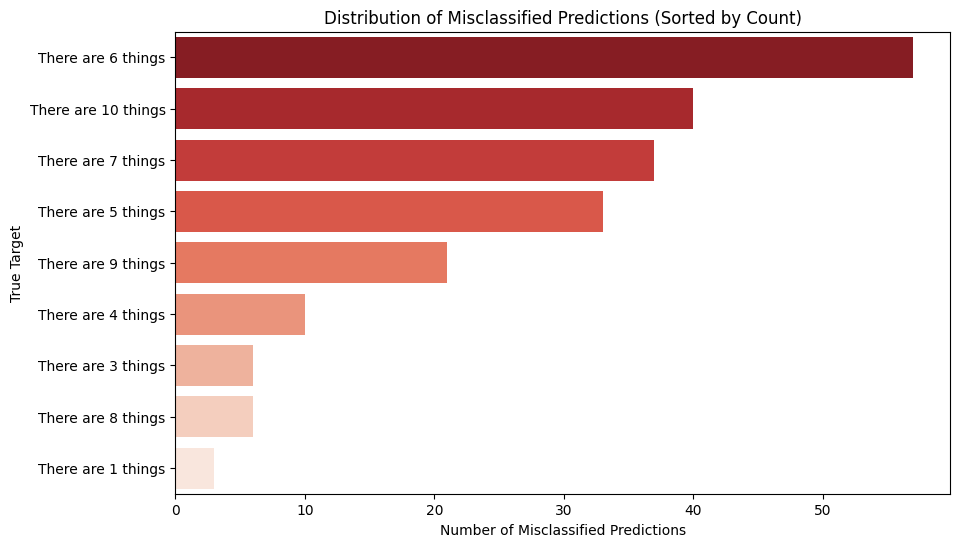


Detailed Misclassification Breakdown:
            True Target     Predicted Target  Count
7    There are 6 things   There are 5 things     56
2   There are 10 things   There are 9 things     37
9    There are 7 things   There are 6 things     36
6    There are 5 things   There are 4 things     33
14   There are 9 things   There are 8 things     20
4    There are 4 things   There are 3 things      9
3    There are 3 things   There are 2 things      6
11   There are 8 things   There are 7 things      5
0    There are 1 things   There are 2 things      3
1   There are 10 things   There are 8 things      3
5    There are 4 things   There are 7 things      1
10   There are 7 things   There are 8 things      1
8    There are 6 things   There are 7 things      1
12   There are 8 things   There are 9 things      1
13   There are 9 things  There are 10 things      1


In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []

# Process images and compute features
for filename in tqdm(image_list):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)

    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(image_list):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(image_list)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results.csv", sep=";", decimal=",", index=False)


# TRAIN TEMP 1

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# SEED
seed = 42
torch.manual_seed(seed)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.train().to(device)

# Split into training and testing sets (80/20 ratio)
image_train, image_test, target_train, target_test = train_test_split(
    image_list, targets, test_size=0.2, random_state=4, stratify=targets
)

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor, data_path):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor
        self.data_path = data_path

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(os.path.join(self.data_path, image_path))  # Combine the data_path and image path
        caption = f'There are {self.targets[idx]} things'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]

# Function to create datasets
def create_datasets(image_train, target_train, image_test, target_test, data_path):
    # Create dataset instances
    train_dataset = CustomDataset(image_train, target_train, processor, data_path)
    test_dataset = CustomDataset(image_test, target_test, processor, data_path)
    
    return train_dataset, test_dataset

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_train, target_train, image_test, target_test, data_path)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=1)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

Epoch 1/10:  75%|███████▍  | 47/63 [04:12<01:25,  5.37s/it, loss=3.33]


KeyboardInterrupt: 

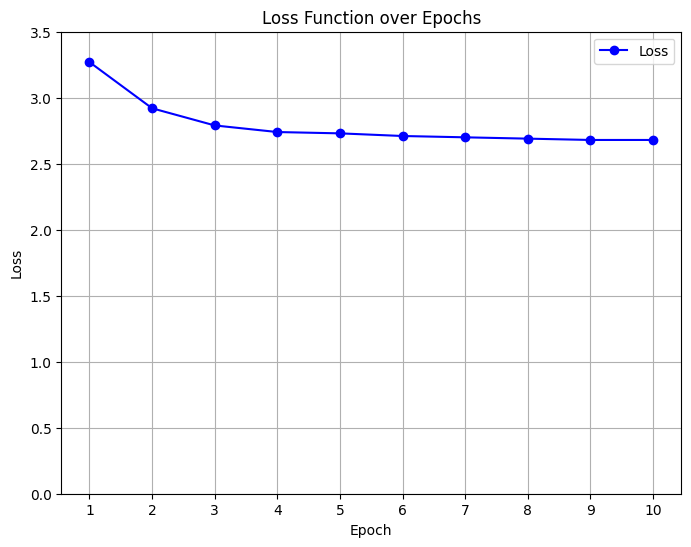

In [6]:
import matplotlib.pyplot as plt

# Loss values for each epoch
loss_values = [3.27, 2.92, 2.79, 2.74, 2.73, 2.71, 2.70, 2.69, 2.68, 2.68]

# Epochs
epochs = list(range(1, 11))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.ylim(0,3.50)
plt.grid(True)
plt.legend()
plt.show()


### Compute image and text embeddings

In [8]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []

# Process images and compute features
for filename in tqdm(image_list):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)

    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(image_list):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(apple_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results_temp1.csv", sep=";", decimal=",", index=False)


cuda


  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [02:55<00:00, 14.21it/s]


# TRAIN ON THREE CATEGORIES TEST ON OTHER TWO

### Train and evaluation

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset 
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from info_nce import InfoNCE  # Assuming this is the correct import
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

seed = 42
torch.manual_seed(seed)
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, targets, processor):
        self.image_paths = image_paths
        self.targets = targets
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        caption = f'There are {self.targets[idx]} things in this image'
        
        # Preprocessing the image and caption
        inputs = self.processor(text=caption, images=image, return_tensors="pt", padding="max_length", max_length=77)
        
        # Returning processed image and text input
        return inputs['pixel_values'].squeeze(0), inputs['input_ids'].squeeze(0), self.targets[idx]


# Function to create train/test datasets
def create_datasets(image_list, random_seed=4):
    """
    Splits the dataset into training and testing sets.
    
    Args:
        image_paths (list): List of paths to images.
        targets (list): List of target labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        train_dataset (CustomDataset): Training dataset.
        test_dataset (CustomDataset): Testing dataset.
    """
    # Split into training and testing sets
    
    # Updated categories
    categories_train = ['butterflies', 'people', 'apples']  # Test categories become train
    categories_test = ['dots', 'fastcards']  # Train categories become eval
    
    train_paths = [
        os.path.join(data_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_train) and file_name.endswith('.png')
    ]
    
    train_targets = [
        'There are' + f.split('_')[0]+ ' things' 
        for f in image_list 
        if any(category in f for category in categories_train) and f.endswith('.png')
    ]

    test_paths = [
        os.path.join(data_path, file_name) 
        for file_name in image_list 
        if any(category in file_name for category in categories_test) and file_name.endswith('.png')
    ]
    
    test_targets = [
        'There are' + f.split('_')[0]+ ' things'  
        for f in image_list 
        if any(category in f for category in categories_test) and f.endswith('.png')
    ]
    # Create dataset instances
    train_dataset = CustomDataset(train_paths, train_targets, processor)
    test_dataset = CustomDataset(test_paths, test_targets, processor)
    
    return train_dataset, test_dataset


# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").train().to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create train and test datasets
train_dataset, test_dataset = create_datasets(image_list)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device).train()

# Training setup
loss_fn = InfoNCE(negative_mode="paired", temperature=0.001)  # Set to paired mode
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0  # Variable to track correct predictions during training
    total_train = 0    # Variable to track total samples during training
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", dynamic_ncols=True)
    
    for batch in progress_bar:
        # Move data to the device (GPU if available)
        image_inputs, text_inputs, targ = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Forward pass to obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Calculate the loss (paired mode automatically uses negatives from the batch)
        loss = loss_fn(image_embeddings, text_embeddings)
        
        # Backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy during training
        similarity_matrix = cosine_similarity(image_embeddings.detach().cpu().numpy(), text_embeddings.detach().cpu().numpy())
        for idx, ta in enumerate(targ):
            most_similar_idx = similarity_matrix[idx].argmax()
            if targ[most_similar_idx] == ta:
                correct_train += 1
            total_train += 1
        
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    
    # Print training accuracy after 5 epochs
    if (epoch + 1) % 5 == 0:
        train_accuracy = correct_train / total_train
        print(f"Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}")

# Evaluation
model.eval()

all_image_embeddings = []
all_text_embeddings = []
all_targets = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Evaluating", dynamic_ncols=True)
    
    for batch in progress_bar:
        image_inputs, text_inputs, tar = batch
        image_inputs = image_inputs.to(device)
        text_inputs = text_inputs.to(device)
        
        # Obtain embeddings
        image_embeddings = model.get_image_features(pixel_values=image_inputs)
        text_embeddings = model.get_text_features(input_ids=text_inputs)
        
        # Normalize embeddings
        image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True)
        
        # Collect embeddings and targets
        all_image_embeddings.append(image_embeddings.cpu())
        all_text_embeddings.append(text_embeddings.cpu())
        all_targets.extend(tar)  # Collect targets for evaluation
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

    # Ensure that image and text embeddings match in size
    assert all_image_embeddings.size(0) == all_text_embeddings.size(0), \
        f"Size mismatch: {all_image_embeddings.size(0)} != {all_text_embeddings.size(0)}"

    # Convert to numpy for similarity calculation
    all_image_embeddings = all_image_embeddings.numpy()
    all_text_embeddings = all_text_embeddings.numpy()

    # Compute cosine similarity between image and text embeddings
    similarity_matrix = cosine_similarity(all_image_embeddings, all_text_embeddings)

    # Evaluation: Check if highest similarity aligns with correct targets
    correct = 0
    for idx, ta in enumerate(all_targets):
        # Find the most similar text embedding to the image embedding
        most_similar_idx = similarity_matrix[idx].argmax()
        
        # Ensure the most similar index is valid
        if all_targets[most_similar_idx] == ta:
            correct += 1
    
    # Calculate accuracy
    accuracy = correct / len(all_targets)
    print(f"Evaluation Accuracy: {accuracy:.4f}")

Epoch 5/10: 100%|██████████| 47/47 [02:52<00:00,  3.68s/it, loss=1.53]


Training Accuracy after Epoch 5: 0.8927


Epoch 10/10: 100%|██████████| 47/47 [03:04<00:00,  3.92s/it, loss=1.41]


Training Accuracy after Epoch 10: 0.9727


Evaluating: 100%|██████████| 32/32 [00:40<00:00,  1.26s/it]

Evaluation Accuracy: 0.3570


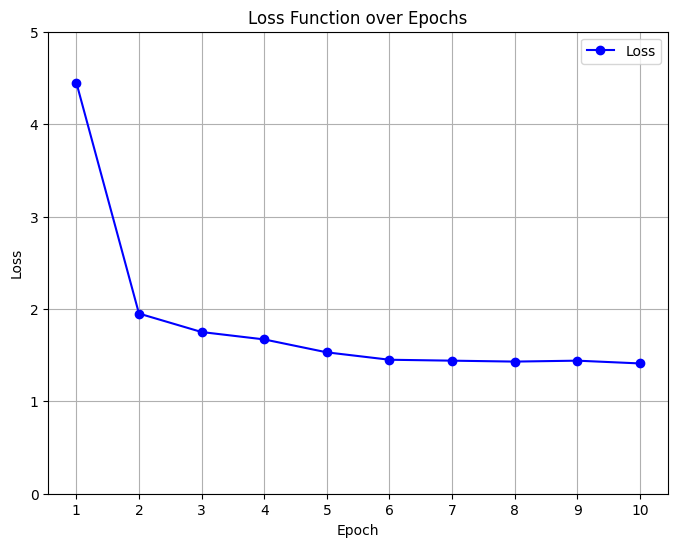

In [12]:
import matplotlib.pyplot as plt

# Loss values for each epoch
loss_values = [4.45, 1.95, 1.75, 1.67, 1.53, 1.45, 1.44, 1.43, 1.44, 1.41]

# Epochs
epochs = list(range(1, 11))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.ylim(0,5)
plt.grid(True)
plt.legend()
plt.show()


### Compute image and text embeddings for the two categories


In [ ]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Updated categories
categories_test = ['dots', 'fastcards']  # Test categories become train
categories_train = ['butterflies', 'people', 'apples']  # Train categories become eval

train_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_train) and file_name.endswith('.png')
]

train_targets = [
    'There are'+ f.split('_')[0]+' things'  
    for f in image_list 
    if any(category in f for category in categories_train) and f.endswith('.png')
]

test_files = [
    file_name 
    for file_name in image_list 
    if any(category in file_name for category in categories_test) and file_name.endswith('.png') #and file_name.split('_')[0] == '1'
]

test_target = [
    'There are'+ f.split('_')[0] +' things' 
    for f in image_list 
    if any(category in f for category in categories_test) and f.endswith('.png')
]



# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []


# Process images and compute features
for filename in tqdm(test_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)
    
    # Open and preprocess the image
    im = Image.open(data_path + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(test_files):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(test_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results_partial_temp_0.0001_TRAIN.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Calculate the means of the embeddings
mean_image_embedding = np.mean(image_features, axis=0)  # Mean of all image embeddings
mean_text_embedding = np.mean(text_features, axis=0)    # Mean of all text embeddings

# Normalize the means
mean_image_embedding = mean_image_embedding / np.linalg.norm(mean_image_embedding)
mean_text_embedding = mean_text_embedding / np.linalg.norm(mean_text_embedding)

# Compute the gap (∆gap)
delta_gap = np.linalg.norm(mean_image_embedding - mean_text_embedding)

# Print the metric
print(f"Delta Gap (∆gap): {delta_gap:.4f}")

100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s]

Total Examples: 1000
Correct Predictions: 312
Misclassified Predictions: 688
Accuracy: 0.3120

Cosine Similarity Statistics:
Correct Matches - Mean: 0.236, Min: 0.207, Max: 0.272
Misclassified Matches - Mean: 0.231, Min: 0.192, Max: 0.272

Euclidean Distance Statistics:
Correct Matches - Mean: 1.236, Min: 1.207, Max: 1.259
Misclassified Matches - Mean: 1.240, Min: 1.207, Max: 1.271

Correct Predictions by Target:
True Target
There are 1 things     45
There are 10 things    30
There are 2 things     34
There are 3 things     51
There are 4 things     37
There are 5 things     21
There are 6 things     12
There are 7 things      2
There are 8 things     63
There are 9 things     17
dtype: int64

Misclassified Predictions by Target:
True Target
There are 1 things     55
There are 10 things    70
There are 2 things     66
There are 3 things     49
There are 4 things     63
There are 5 things     79
There are 6 things     88
There are 7 things     98
There are 8 things     37
There are 9 th

# CLIP Test and Missclassification Analysis

In [5]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize processor and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Prepare lists to store features
image_features, text_features, targets = [], [], []


# Process images and compute features
for filename in tqdm(test_files):
    target = int(filename.split('_')[0])  # Extract the number from the filename
    caption = f'There are {target} things'  # Text input is just the number as a string
    
    targets.append(caption)

    datapath = '/kaggle/input/imaging/numerosity_naming_images/'
    
    # Open and preprocess the image
    im = Image.open(datapath + filename)
    inputs = processor(text=[caption], images=im, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        # Get the image and text features
        outputs = model(**inputs)
        
        # Get image features using model's get_image_features method
        image_feat = model.get_image_features(inputs['pixel_values'])
        image_feat = image_feat[0]  # Get the first (and only) image features
        
        # Get text features using model's get_text_features method
        text_feat = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Normalize features
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    
    # Append features to lists
    image_features.append(image_feat.cpu().numpy())
    text_features.append(text_feat.cpu().numpy())

# Convert lists to numpy arrays then to tensors
image_features = np.array(image_features)  # Shape: (500, 512)
text_features = np.array(text_features).squeeze(1)  # Shape: (500, 512)

from scipy.spatial.distance import euclidean


# Evaluate matches and mismatches
correct_count = 0
misclassified_count = 0
results = []  # To store evaluation details for analysis
    # Now calculate the cosine similarity
cos_sim_matrix = cosine_similarity(image_features, text_features)

for idx, filename in enumerate(test_files):
    # Find the most similar target based on cosine similarity
    most_similar_idx = cos_sim_matrix[idx].argmax()
    predicted_target = targets[most_similar_idx]
    true_target = targets[idx]

    # Calculate the Euclidean distance between image and text features
    image_feat = image_features[idx]
    text_feat = text_features[most_similar_idx]
    euclid_dist = euclidean(image_feat, text_feat)

    # Check if prediction is correct
    if predicted_target == true_target:
        correct_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": True
        }
    else:
        misclassified_count += 1
        result = {
            "Image": filename,
            "True Target": true_target,
            "Predicted Target": predicted_target,
            "Similarity": cos_sim_matrix[idx, most_similar_idx],
            "Euclidean Distance": euclid_dist,
            "Correct": False
        }
    results.append(result)

# Calculate accuracy
total = len(apple_files)
accuracy = correct_count / total

# Convert results to a DataFrame for detailed analysis
results_df = pd.DataFrame(results)

# Save evaluation details to a CSV file
results_df.to_csv("evaluation_results.csv", sep=";", decimal=",", index=False)

# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Filter misclassified predictions
misclassified_df = results_df[~results_df["Correct"]]

# Group by True Target and count misclassifications
misclassified_distribution = misclassified_df.groupby("True Target").size().sort_values(ascending=False)

print("\nMisclassified Predictions Distribution (Sorted):")
print(misclassified_distribution)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=misclassified_distribution.values,
    y=misclassified_distribution.index,
    palette="Reds_r",
)
plt.title("Distribution of Misclassified Predictions (Sorted by Count)")
plt.xlabel("Number of Misclassified Predictions")
plt.ylabel("True Target")
plt.show()

# Group by True Target and Predicted Target
misclassified_details = (
    misclassified_df.groupby(["True Target", "Predicted Target"])
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)

print("\nDetailed Misclassification Breakdown:")
print(misclassified_details)

# Optional: Save the detailed breakdown to a CSV file for further analysis
misclassified_details.to_csv("misclassified_details_partial_temp_0.0001.csv", sep=";", decimal=",", index=False)


NameError: name 'test_files' is not defined

# Visualizations

In [43]:
results_df = pd.read_csv("evaluation_results_partial_temp1.csv", sep=";", decimal=",")

### INIT visualizations

Total Examples: 2500
Correct Predictions: 556
Misclassified Predictions: 1944
Accuracy: 0.2224

Cosine Similarity Statistics:
Correct Matches - Mean: 0.229, Min: 0.199, Max: 0.266
Misclassified Matches - Mean: 0.224, Min: 0.185, Max: 0.260

Euclidean Distance Statistics:
Correct Matches - Mean: 1.242, Min: 1.211, Max: 1.266
Misclassified Matches - Mean: 1.246, Min: 1.216, Max: 1.276

Correct Predictions by Target:
True Target
There are 1 things      44
There are 10 things      9
There are 2 things     109
There are 3 things     102
There are 4 things      25
There are 5 things      26
There are 6 things       2
There are 7 things       2
There are 8 things     123
There are 9 things     114
dtype: int64

Misclassified Predictions by Target:
True Target
There are 1 things     206
There are 10 things    241
There are 2 things     141
There are 3 things     148
There are 4 things     225
There are 5 things     224
There are 6 things     248
There are 7 things     248
There are 8 things   

C:\Users\matti\AppData\Local\Temp\ipykernel_14720\663678970.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


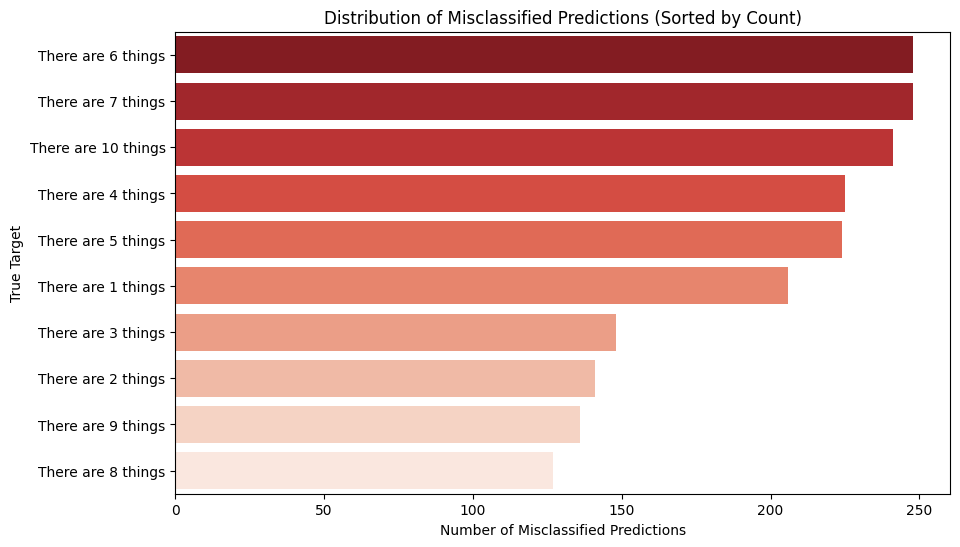


Detailed Misclassification Breakdown:
            True Target    Predicted Target  Count
53   There are 7 things  There are 8 things    130
47   There are 6 things  There are 8 things    125
40   There are 5 things  There are 8 things    123
11  There are 10 things  There are 9 things    118
3    There are 1 things  There are 8 things    115
..                  ...                 ...    ...
7   There are 10 things  There are 3 things      1
5   There are 10 things  There are 1 things      1
35   There are 5 things  There are 2 things      1
46   There are 6 things  There are 7 things      1
61   There are 9 things  There are 3 things      1

[65 rows x 3 columns]


In [ ]:
# Print summary statistics
print(f"Total Examples: {total}")
print(f"Correct Predictions: {correct_count}")
print(f"Misclassified Predictions: {misclassified_count}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, calculate detailed statistics for cosine similarity and Euclidean distance of correct and misclassified matches
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

print("\nCosine Similarity Statistics:")
print(f"Correct Matches - Mean: {correct_similarities.mean():.3f}, Min: {correct_similarities.min():.3f}, Max: {correct_similarities.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_similarities.mean():.3f}, Min: {misclassified_similarities.min():.3f}, Max: {misclassified_similarities.max():.3f}")

print("\nEuclidean Distance Statistics:")
print(f"Correct Matches - Mean: {correct_euclid_distances.mean():.3f}, Min: {correct_euclid_distances.min():.3f}, Max: {correct_euclid_distances.max():.3f}")
print(f"Misclassified Matches - Mean: {misclassified_euclid_distances.mean():.3f}, Min: {misclassified_euclid_distances.min():.3f}, Max: {misclassified_euclid_distances.max():.3f}")

# Example output: How well does the model distinguish between targets?
correct_by_target = results_df[results_df["Correct"]].groupby("True Target").size()
misclassified_by_target = results_df[~results_df["Correct"]].groupby("True Target").size()

print("\nCorrect Predictions by Target:")
print(correct_by_target)

print("\nMisclassified Predictions by Target:")
print(misclassified_by_target)


# Filter misclassified predictions
misclassified_df = results_df[~results_df["Correct"]]

# Group by True Target and count misclassifications
misclassified_distribution = misclassified_df.groupby("True Target").size().sort_values(ascending=False)

# Group by True Target and Predicted Target
misclassified_details = (
    misclassified_df.groupby(["True Target", "Predicted Target"])
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)

print("\nDetailed Misclassification Breakdown:")
print(misclassified_details)

# Optional: Save the detailed breakdown to a CSV file for further analysis
misclassified_details.to_csv("misclassified_details_partial_temp0.0001.csv", sep=";", decimal=",", index=False)

### Metrics and overall statistics

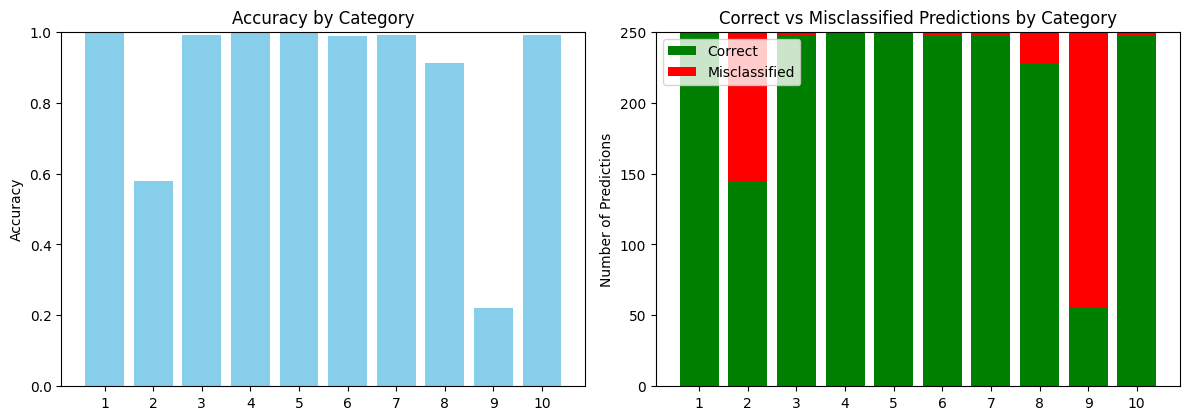

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.read_csv("evaluation_results_temp1.csv", sep=";", decimal=",")


# Compute the necessary statistics from the results_df
accuracy = results_df["Correct"].mean()  # Calculate overall accuracy
total_examples = len(results_df)
correct_predictions = results_df["Correct"].sum()
misclassified_predictions = total_examples - correct_predictions



# Cosine similarity and Euclidean distance for correct and misclassified
correct_similarities = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances = results_df[~results_df["Correct"]]["Euclidean Distance"]

# Create a new DataFrame for plotting by category (based on true target)
category_stats = results_df.groupby("True Target").agg(
    Correct=("Correct", "sum"),
    Misclassified=("Correct", lambda x: len(x) - x.sum()),
    Accuracy=("Correct", lambda x: x.sum() / len(x)),
    Cosine_Mean_Correct=("Similarity", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Cosine_Mean_Misclassified=("Similarity", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0),
    Euclidean_Mean_Correct=("Euclidean Distance", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Euclidean_Mean_Misclassified=("Euclidean Distance", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0)
).reset_index()

# Extract the numeric part from 'True Target' and convert to integers
category_stats["Numeric_Target"] = category_stats["True Target"].str.extract('(\d+)').astype(int)

# Filter out categories where there are no correct predictions (Accuracy is 0)
category_stats_filtered = category_stats[category_stats["Correct"] > 0]

# Sort by the extracted numeric values
category_stats_filtered = category_stats_filtered.sort_values(by="Numeric_Target")

# Visualization
plt.figure(figsize=(12, 8))

# Accuracy bar chart by category
plt.subplot(2, 2, 1)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Accuracy"], color="skyblue")
plt.title("Accuracy by Category")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Fix y-axis for accuracy
plt.xticks(category_stats_filtered["Numeric_Target"])


# Correct vs Misclassified Predictions by category
plt.subplot(2, 2, 2)
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Correct"], color="green", label="Correct")
plt.bar(category_stats_filtered["Numeric_Target"], category_stats_filtered["Misclassified"], bottom=category_stats_filtered["Correct"], color="red", label="Misclassified")
plt.title("Correct vs Misclassified Predictions by Category")
plt.ylabel("Number of Predictions")
plt.legend()
plt.xticks(category_stats_filtered["Numeric_Target"])

plt.tight_layout()
plt.savefig("results_plots.png")
plt.show()


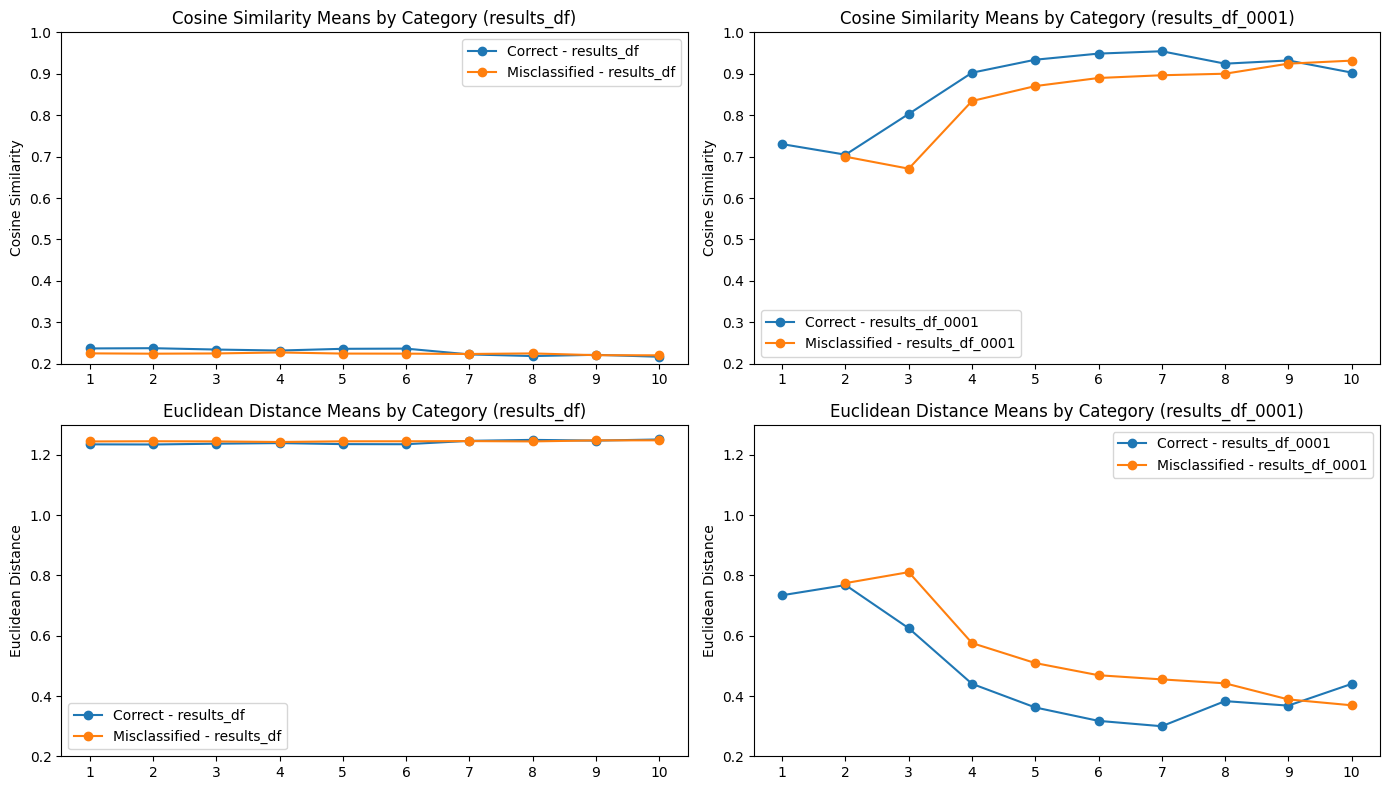

Results_df - Cosine Similarity (Correct): 0.0005
Results_df - Cosine Similarity (Misclassified): 0.0002
Results_0001 - Cosine Similarity (Correct): 0.0019
Results_0001 - Cosine Similarity (Misclassified): 0.0057
Results_df - Euclidean Distance (Correct): 0.0004
Results_df - Euclidean Distance (Misclassified): 0.0002
Results_0001 - Euclidean Distance (Correct): 0.0035
Results_0001 - Euclidean Distance (Misclassified): 0.0098
T-test results for Cosine Similarity (results_df): p-value = 0.0000
T-test results for Euclidean Distance (results_df): p-value = 0.0000
T-test results for Cosine Similarity (results_df_0001): p-value = 0.0000
T-test results for Euclidean Distance (results_df_0001): p-value = 0.0000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Load the CSV files
results_df = pd.read_csv("evaluation_results.csv", sep=";", decimal=",")
results_df_0001 = pd.read_csv("evaluation_results_temp1.csv", sep=";", decimal=",")

# Compute statistics for results_df
accuracy = results_df["Correct"].mean()
total_examples = len(results_df)
correct_predictions = results_df["Correct"].sum()
misclassified_predictions = total_examples - correct_predictions

# Cosine similarity and Euclidean distance for correct and misclassified (results_df)
correct_similarities_df = results_df[results_df["Correct"]]["Similarity"]
misclassified_similarities_df = results_df[~results_df["Correct"]]["Similarity"]
correct_euclid_distances_df = results_df[results_df["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances_df = results_df[~results_df["Correct"]]["Euclidean Distance"]

# Cosine similarity and Euclidean distance for correct and misclassified (results_df_0001)
correct_similarities_0001 = results_df_0001[results_df_0001["Correct"]]["Similarity"]
misclassified_similarities_0001 = results_df_0001[~results_df_0001["Correct"]]["Similarity"]
correct_euclid_distances_0001 = results_df_0001[results_df_0001["Correct"]]["Euclidean Distance"]
misclassified_euclid_distances_0001 = results_df_0001[~results_df_0001["Correct"]]["Euclidean Distance"]

# Create a new DataFrame for plotting by category (based on true target) for results_df
category_stats_df = results_df.groupby("True Target").agg(
    Correct=("Correct", "sum"),
    Misclassified=("Correct", lambda x: len(x) - x.sum()),
    Accuracy=("Correct", lambda x: x.sum() / len(x)),
    Cosine_Mean_Correct=("Similarity", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Cosine_Mean_Misclassified=("Similarity", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0),
    Euclidean_Mean_Correct=("Euclidean Distance", lambda x: x[results_df["Correct"]].mean() if x[results_df["Correct"]].any() else 0),
    Euclidean_Mean_Misclassified=("Euclidean Distance", lambda x: x[~results_df["Correct"]].mean() if (~results_df["Correct"]).any() else 0)
).reset_index()

# Create a new DataFrame for plotting by category (based on true target) for results_df_0001
category_stats_0001 = results_df_0001.groupby("True Target").agg(
    Correct=("Correct", "sum"),
    Misclassified=("Correct", lambda x: len(x) - x.sum()),
    Accuracy=("Correct", lambda x: x.sum() / len(x)),
    Cosine_Mean_Correct=("Similarity", lambda x: x[results_df_0001["Correct"]].mean() if x[results_df_0001["Correct"]].any() else 0),
    Cosine_Mean_Misclassified=("Similarity", lambda x: x[~results_df_0001["Correct"]].mean() if (~results_df_0001["Correct"]).any() else 0),
    Euclidean_Mean_Correct=("Euclidean Distance", lambda x: x[results_df_0001["Correct"]].mean() if x[results_df_0001["Correct"]].any() else 0),
    Euclidean_Mean_Misclassified=("Euclidean Distance", lambda x: x[~results_df_0001["Correct"]].mean() if (~results_df_0001["Correct"]).any() else 0)
).reset_index()

# Extract the numeric part from 'True Target' and convert to integers for both dataframes
category_stats_df["Numeric_Target"] = category_stats_df["True Target"].str.extract('(\d+)').astype(int)
category_stats_0001["Numeric_Target"] = category_stats_0001["True Target"].str.extract('(\d+)').astype(int)

# Filter out categories where there are no correct predictions (Accuracy is 0)
category_stats_df_filtered = category_stats_df[category_stats_df["Correct"] > 0]
category_stats_0001_filtered = category_stats_0001[category_stats_0001["Correct"] > 0]

# Sort by the extracted numeric values
category_stats_df_filtered = category_stats_df_filtered.sort_values(by="Numeric_Target")
category_stats_0001_filtered = category_stats_0001_filtered.sort_values(by="Numeric_Target")

# Visualization
plt.figure(figsize=(14, 8))

# Cosine similarity comparison by category (left: results_df, right: results_df_0001)
plt.subplot(2, 2, 1)
plt.plot(category_stats_df_filtered["Numeric_Target"], category_stats_df_filtered["Cosine_Mean_Correct"], marker="o", label="Correct - results_df")
plt.plot(category_stats_df_filtered["Numeric_Target"], category_stats_df_filtered["Cosine_Mean_Misclassified"], marker="o", label="Misclassified - results_df")
plt.title("Cosine Similarity Means by Category (results_df)")
plt.ylabel("Cosine Similarity")
plt.ylim(0.2,1)  # Fix y-axis for cosine similarity
plt.legend()
plt.xticks(category_stats_df_filtered["Numeric_Target"])

plt.subplot(2, 2, 2)
plt.plot(category_stats_0001_filtered["Numeric_Target"], category_stats_0001_filtered["Cosine_Mean_Correct"], marker="o", label="Correct - results_df_0001")
plt.plot(category_stats_0001_filtered["Numeric_Target"], category_stats_0001_filtered["Cosine_Mean_Misclassified"], marker="o", label="Misclassified - results_df_0001")
plt.title("Cosine Similarity Means by Category (results_df_0001)")
plt.ylabel("Cosine Similarity")
plt.ylim(0.2,1)  # Fix y-axis for cosine similarity
plt.legend()
plt.xticks(category_stats_0001_filtered["Numeric_Target"])


# Euclidean distance comparison by category (left: results_df, right: results_df_0001)
plt.subplot(2, 2, 3)
plt.plot(category_stats_df_filtered["Numeric_Target"], category_stats_df_filtered["Euclidean_Mean_Correct"], marker="o", label="Correct - results_df")
plt.plot(category_stats_df_filtered["Numeric_Target"], category_stats_df_filtered["Euclidean_Mean_Misclassified"], marker="o", label="Misclassified - results_df")
plt.title("Euclidean Distance Means by Category (results_df)")
plt.ylabel("Euclidean Distance")
plt.ylim(0.2, 1.3)
plt.legend()
plt.xticks(category_stats_df_filtered["Numeric_Target"])

plt.subplot(2, 2, 4)
plt.plot(category_stats_0001_filtered["Numeric_Target"], category_stats_0001_filtered["Euclidean_Mean_Correct"], marker="o", label="Correct - results_df_0001")
plt.plot(category_stats_0001_filtered["Numeric_Target"], category_stats_0001_filtered["Euclidean_Mean_Misclassified"], marker="o", label="Misclassified - results_df_0001")
plt.title("Euclidean Distance Means by Category (results_df_0001)")
plt.ylabel("Euclidean Distance")
plt.ylim(0.2, 1.3)
plt.legend()
plt.xticks(category_stats_0001_filtered["Numeric_Target"])

plt.tight_layout()
plt.savefig("comparison_plots.png")
plt.show()

# Calculate Standard Error for Cosine Similarity and Euclidean Distance for each results file
def compute_standard_error(data):
    return np.std(data) / np.sqrt(len(data))

# Standard error for cosine similarity (correct, misclassified)
cosine_se_df_correct = compute_standard_error(correct_similarities_df)
cosine_se_df_misclassified = compute_standard_error(misclassified_similarities_df)
cosine_se_0001_correct = compute_standard_error(correct_similarities_0001)
cosine_se_0001_misclassified = compute_standard_error(misclassified_similarities_0001)

# Standard error for Euclidean distance (correct, misclassified)
euclidean_se_df_correct = compute_standard_error(correct_euclid_distances_df)
euclidean_se_df_misclassified = compute_standard_error(misclassified_euclid_distances_df)
euclidean_se_0001_correct = compute_standard_error(correct_euclid_distances_0001)
euclidean_se_0001_misclassified = compute_standard_error(misclassified_euclid_distances_0001)

# Print Standard Errors
print(f"Results_df - Cosine Similarity (Correct): {cosine_se_df_correct:.4f}")
print(f"Results_df - Cosine Similarity (Misclassified): {cosine_se_df_misclassified:.4f}")
print(f"Results_0001 - Cosine Similarity (Correct): {cosine_se_0001_correct:.4f}")
print(f"Results_0001 - Cosine Similarity (Misclassified): {cosine_se_0001_misclassified:.4f}")
print(f"Results_df - Euclidean Distance (Correct): {euclidean_se_df_correct:.4f}")
print(f"Results_df - Euclidean Distance (Misclassified): {euclidean_se_df_misclassified:.4f}")
print(f"Results_0001 - Euclidean Distance (Correct): {euclidean_se_0001_correct:.4f}")
print(f"Results_0001 - Euclidean Distance (Misclassified): {euclidean_se_0001_misclassified:.4f}")

# Statistical test within results_df
cosine_ttest_df = stats.ttest_ind(correct_similarities_df, misclassified_similarities_df)
euclidean_ttest_df = stats.ttest_ind(correct_euclid_distances_df, misclassified_euclid_distances_df)

# Statistical test within results_df_0001
cosine_ttest_0001 = stats.ttest_ind(correct_similarities_0001, misclassified_similarities_0001)
euclidean_ttest_0001 = stats.ttest_ind(correct_euclid_distances_0001, misclassified_euclid_distances_0001)

# Print T-tests results
print(f"T-test results for Cosine Similarity (results_df): p-value = {cosine_ttest_df.pvalue:.4f}")
print(f"T-test results for Euclidean Distance (results_df): p-value = {euclidean_ttest_df.pvalue:.4f}")
print(f"T-test results for Cosine Similarity (results_df_0001): p-value = {cosine_ttest_0001.pvalue:.4f}")
print(f"T-test results for Euclidean Distance (results_df_0001): p-value = {euclidean_ttest_0001.pvalue:.4f}")


### Classification Matrix

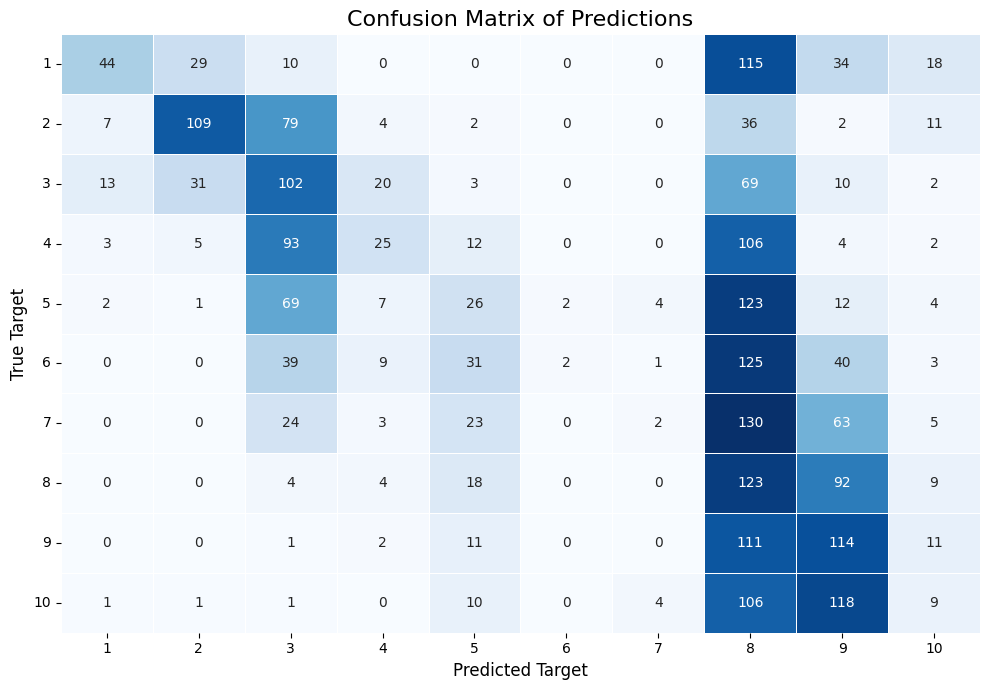

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract numbers from the labels and sort them
sorted_labels = sorted(
    results_df['True Target'].unique(), 
    key=lambda x: int(x.split()[2])  # Extract the number from the string
)

# Create confusion matrix
conf_matrix = confusion_matrix(
    results_df['True Target'], 
    results_df['Predicted Target'], 
    labels=sorted_labels
)

# Extract only the number part of the labels for axis ticks
label_numbers = [label.split()[2] for label in sorted_labels]

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=label_numbers,  # Use numbers only
    yticklabels=label_numbers,  # Use numbers only
    cbar=False,
    linewidths=0.5
)

# Set labels and title
plt.title("Confusion Matrix of Predictions", fontsize=16)
plt.xlabel("Predicted Target", fontsize=12)
plt.yticks(rotation=0)
plt.ylabel("True Target", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# save results_df to csv
results_df.to_csv("results_df.csv", sep=";", decimal=",", index=False)


### MAE

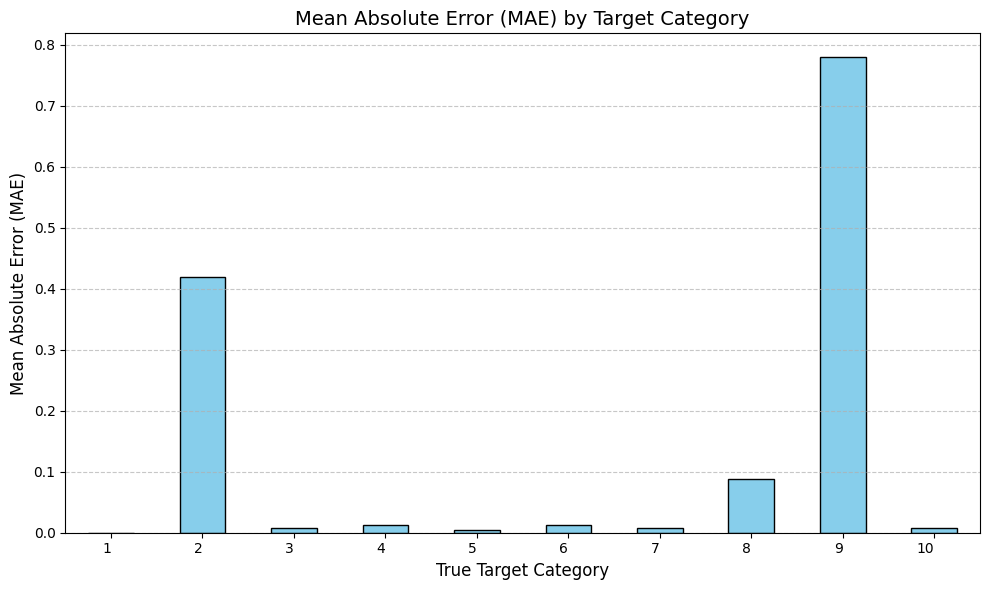

In [37]:
import matplotlib.pyplot as plt

# Extract numerical values from the target columns
results_df["True Target Num"] = results_df["True Target"].str.extract(r'(\d+)').astype(int)
results_df["Predicted Target Num"] = results_df["Predicted Target"].str.extract(r'(\d+)').astype(int)

# Compute absolute error (MAE)
results_df["Absolute Error"] = abs(results_df["True Target Num"] - results_df["Predicted Target Num"])

# Group by target category and calculate mean absolute error
mae_by_target = results_df.groupby("True Target")["Absolute Error"].mean()

# Extract only the numerical part of the target categories for sorting
mae_by_target_sorted = mae_by_target.reindex(sorted(mae_by_target.index, key=lambda x: int(x.split()[2])))

# Extract only the numeric part of the labels for the x-axis
label_numbers = [label.split()[2] for label in mae_by_target_sorted.index]

# Plotting MAE
plt.figure(figsize=(10, 6))
mae_by_target_sorted.plot(kind='bar', color='skyblue', edgecolor='black')

# Modify x-axis labels to show only the numbers
plt.xticks(ticks=range(len(mae_by_target_sorted)), labels=label_numbers, rotation=0, ha="right", fontsize=10)

# Add plot details
plt.title("Mean Absolute Error (MAE) by Target Category", fontsize=14)
plt.xlabel("True Target Category", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


### Classification Report

In [14]:
# Filter misclassified predictions
misclassified_df = results_df[~results_df["Correct"]]

# Group by True Target and count misclassifications
misclassified_distribution = misclassified_df.groupby("True Target").size().sort_values(ascending=False)

print("\nMisclassified Predictions Distribution (Sorted):")
print(misclassified_distribution)
import matplotlib.pyplot as plt
import seaborn as sns
# Group by True Target and Predicted Target
misclassified_details = (
    misclassified_df.groupby(["True Target", "Predicted Target"])
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)

print("\nDetailed Misclassification Breakdown:")
print(misclassified_details)




Misclassified Predictions Distribution (Sorted):
True Target
There are 6 things     248
There are 7 things     248
There are 10 things    241
There are 4 things     225
There are 5 things     224
There are 1 things     206
There are 3 things     148
There are 2 things     141
There are 9 things     136
There are 8 things     127
dtype: int64

Detailed Misclassification Breakdown:
            True Target    Predicted Target  Count
53   There are 7 things  There are 8 things    130
47   There are 6 things  There are 8 things    125
40   There are 5 things  There are 8 things    123
11  There are 10 things  There are 9 things    118
3    There are 1 things  There are 8 things    115
..                  ...                 ...    ...
7   There are 10 things  There are 3 things      1
5   There are 10 things  There are 1 things      1
35   There are 5 things  There are 2 things      1
46   There are 6 things  There are 7 things      1
61   There are 9 things  There are 3 things      1

[65

### SVD

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Normalize features to lie on the surface of a unit hypersphere
def normalize_to_hypersphere(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / norms

# Perform SVD (used for PCA) and calculate explained variance ratio
def perform_svd(X, n_components=10):
    U, S, Vt = np.linalg.svd(X)
    explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
    return U[:, :n_components] * S[:n_components], explained_variance_ratio, S

# Combine and normalize features
combined_features = np.concatenate([image_features, text_features], axis=0)
normalized_features = normalize_to_hypersphere(combined_features)

# Perform SVD for dimensionality reduction
features_2d, evr, S = perform_svd(normalized_features, n_components=10)

# Plot 2D Visualization with SVD components
plt.figure(figsize=(7, 5))
plt.title("Modality Gap (2D View)")

# Plot the image features in blue
plt.scatter(features_2d[:len(image_features), 0], 
            features_2d[:len(image_features), 1], c='blue', label='Image Features')

# Plot the text features in red
plt.scatter(features_2d[len(image_features):, 0], 
            features_2d[len(image_features):, 1], c='red', label='Text Features')

# Connect paired points between modalities with increased transparency
for i in range(len(image_features)):
    plt.plot([features_2d[i, 0], features_2d[len(image_features) + i, 0]],
             [features_2d[i, 1], features_2d[len(image_features) + i, 1]],
             c='black', alpha=0.05)  # Adjust alpha for more transparency

plt.legend()
plt.show()

# Scree plot for the first 10 components
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(evr[:10]) + 1), evr[:10], marker='o', label='Explained Variance Ratio')
plt.title("Scree Plot (First 10 Components)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Cumulative variance plot
cumulative_variance = np.cumsum(evr[:10])
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title("Cumulative Explained Variance (First 10 Components)")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance")

# Find the number of components required for 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.text(num_components_95, 0.95, f'{num_components_95} components', color='black', 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Number of components needed for 95% variance: {num_components_95}")

# 3D Visualization with SVD components
features_3d, _, _ = perform_svd(normalized_features, n_components=3)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Modality Gap (3D View)")

# Plot image features in blue
ax.scatter(features_3d[:len(image_features), 0], 
           features_3d[:len(image_features), 1], 
           features_3d[:len(image_features), 2], c='blue', label='Image Features')

# Plot text features in red
ax.scatter(features_3d[len(image_features):, 0], 
           features_3d[len(image_features):, 1], 
           features_3d[len(image_features):, 2], c='red', label='Text Features')

# Connect paired points between modalities with increased transparency
for i in range(len(image_features)):
    ax.plot([features_3d[i, 0], features_3d[len(image_features) + i, 0]],
            [features_3d[i, 1], features_3d[len(image_features) + i, 1]],
            [features_3d[i, 2], features_3d[len(image_features) + i, 2]],
            c='black', alpha=0.05)  # Adjust alpha for more transparency
# Rotate the view 
ax.view_init(elev=20, azim=60)  # Change azim to rotate the plot

ax.legend()
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

### TSNE

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import time
from scipy.spatial import ConvexHull

# Assuming image_features_proj and text_features are defined, as well as apple_files

data = np.concatenate([image_features, text_features], 0)

# Run t-SNE on data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=400, n_iter=3000, random_state=42)
embedding_tsne = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))


c:\Users\matti\Documents\GitHub\Modality-Gap\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.188831
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.923180
[t-SNE] KL divergence after 3000 iterations: -1.523296
t-SNE done! Time elapsed: 73.16223049163818 seconds


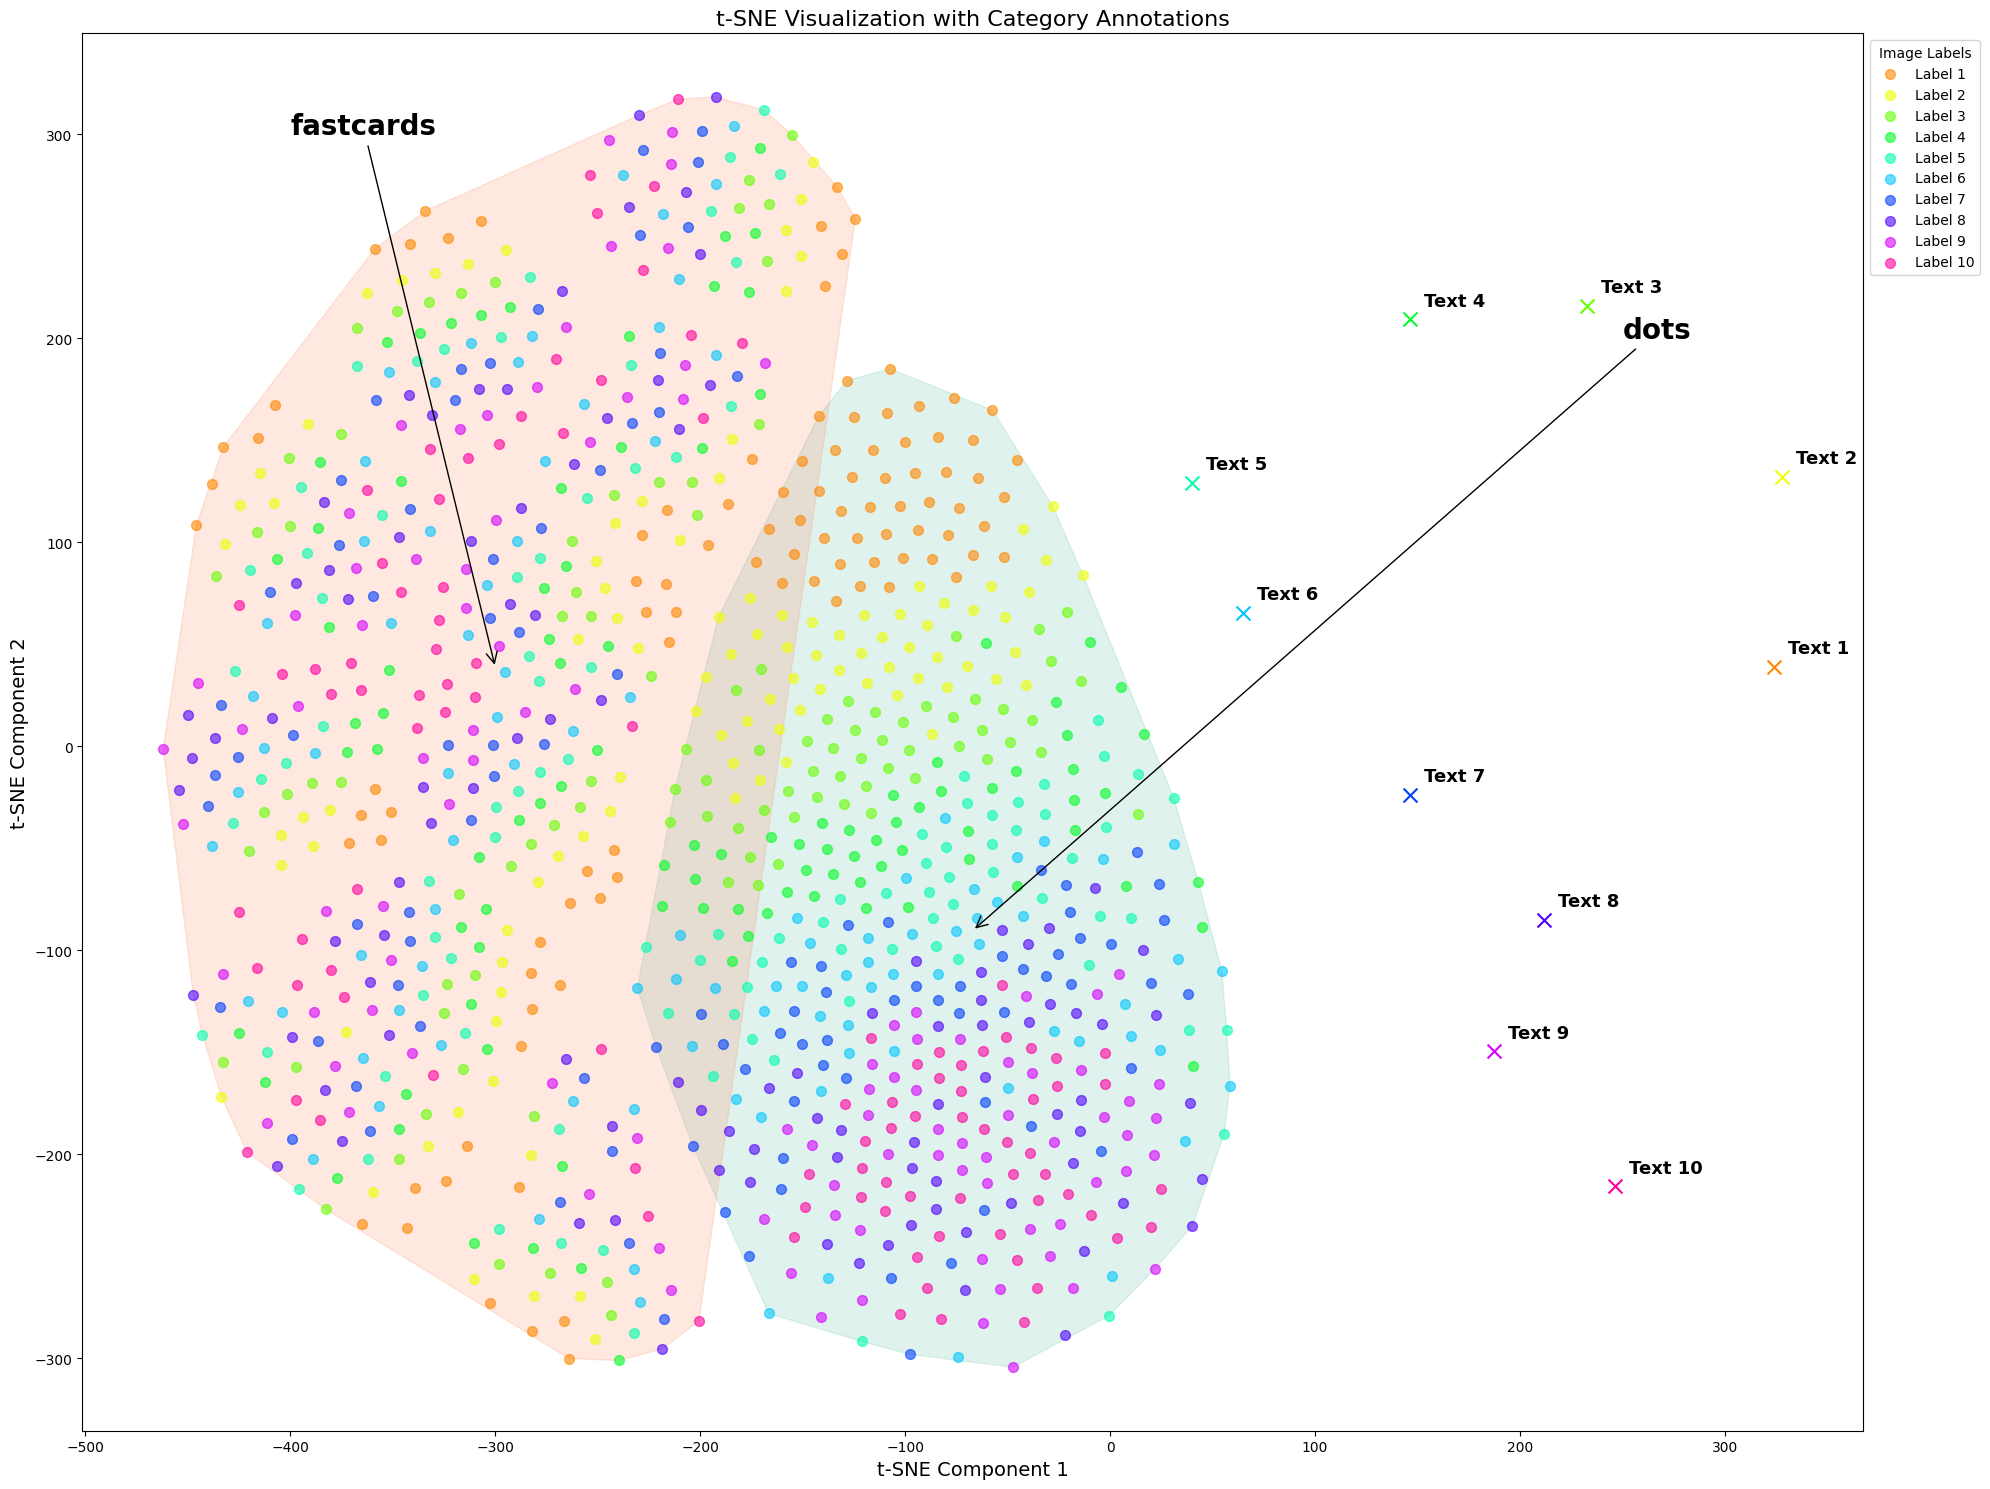

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
image_categories = [filename.split('_')[1] for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]
text_categories = [filename.split('_')[1] for filename in test_files]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Manually defined annotation positions (you can modify these)
category_positions = {
    'apples': (9, 9),   # example x, y coordinates
    'butterflies': (11, 11),  # modify these as needed
    'people': (13, 13),
    'dots': (250, 200),
    'fastcards': (-400, 300)
}

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)
        
        # Calculate centroid of the hull
        centroid = np.mean(current_category_embeddings[hull.vertices], axis=0)
        
        # Check if category has a predefined position
        if category in category_positions:
            annotation_pos = category_positions[category]
            
            # Annotate category with custom position
            plt.annotate(category, 
                         xy=centroid,  # Point to category's centroid
                         xytext=annotation_pos,  # Place text at specified position
                         color='black',
                         fontweight='bold',
                         fontsize=20,  # Increased font size
                         arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)
    
    # Add annotation for text point directly on the point
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(10,10),  # Slight offset to avoid overlapping
                 textcoords='offset points',
                 fontsize=13,
                 color='black',
                 fontweight='bold')

    # Draw an arrow from the text point to the centroid of the image category
    #centroid = np.mean(current_image_embeddings, axis=0)  # Centroid of the image category
    #plt.annotate('', 
    #             xy=(centroid[0], centroid[1]), 
    #             xytext=(text_embedding[0], text_embedding[1]), 
    #             arrowprops=dict(arrowstyle='->', color=image_colors[idx], lw=1))

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
#savefig

### PLOT TSNE JUST 1 CATEGORY IF OVERLAPS

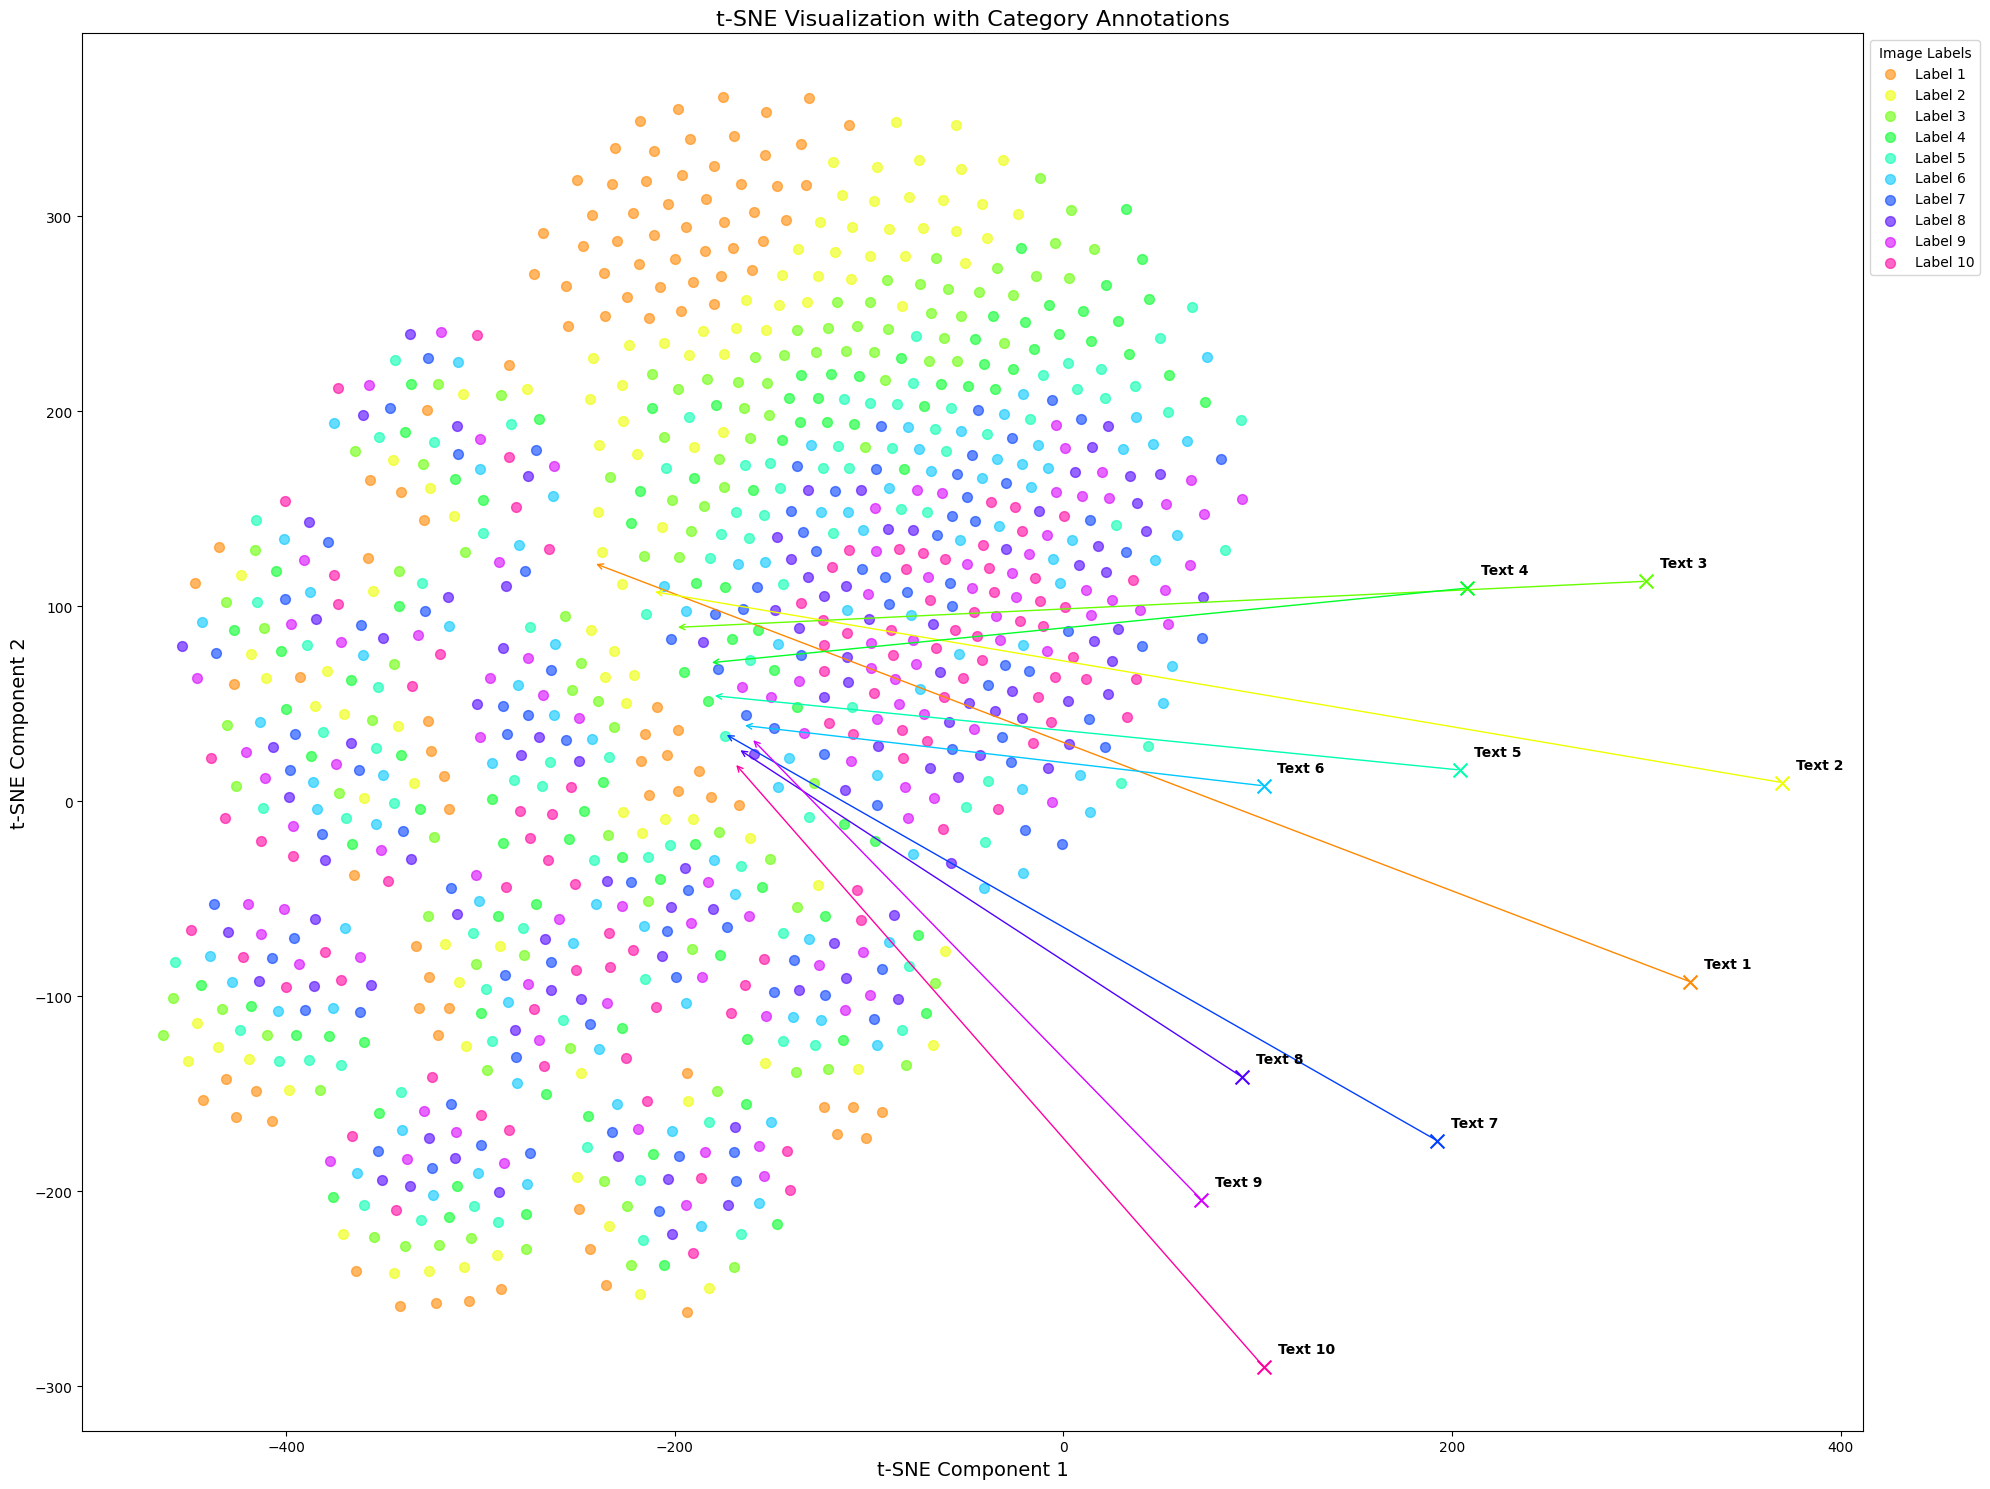

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels and categories from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
image_categories = [filename.split('_')[1] for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]
text_categories = [filename.split('_')[1] for filename in test_files]

# Get unique labels and categories
unique_labels = np.unique(image_labels)
unique_categories = np.unique(image_categories)

# Create color maps
image_colors = sns.color_palette("hsv", len(unique_labels))
category_colors = sns.color_palette("Set2", len(unique_categories))

# Create figure
plt.figure(figsize=(20, 15))

# Manually defined annotation positions (you can modify these)
category_positions = {
    'apples': (9, 9),   # example x, y coordinates
}

# Loop through each unique category
for cat_idx, category in enumerate(unique_categories):
    if category != 'apples':  # Skip categories that are not "apples"
        continue

    # Get indices of images with current category
    category_indices = [i for i, cat in enumerate(image_categories) if cat == category]
    
    # Get the image embeddings for current category
    current_category_embeddings = embedding_tsne[category_indices]
    
    # Create convex hull if we have enough points
    if len(current_category_embeddings) >= 3:
        # Calculate convex hull
        hull = ConvexHull(current_category_embeddings)
        
        # Plot convex hull
        plt.fill(current_category_embeddings[hull.vertices, 0], 
                current_category_embeddings[hull.vertices, 1], 
                color=category_colors[cat_idx], alpha=0.2)
        
        # Calculate centroid of the hull
        centroid = np.mean(current_category_embeddings[hull.vertices], axis=0)
        
        # Check if category has a predefined position
        if category in category_positions:
            annotation_pos = category_positions[category]
            
            # Annotate category with custom position
            plt.annotate('No category clustering', 
                         xy=centroid,  # Point to category's centroid
                         xytext=annotation_pos,  # Place text at specified position
                         color='black',
                         fontweight='bold',
                         fontsize=18,  # Increased font size
                         arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot image points with original label colors
scatter_handles = []
scatter_labels = []

for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Plot the image points with original colors
    scatter = plt.scatter(current_image_embeddings[:, 0], 
               current_image_embeddings[:, 1], 
               c=[image_colors[idx]], s=50, alpha=0.6)
    scatter_handles.append(scatter)
    scatter_labels.append(f'Label {label}')
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot text point with the same color as the image label
    plt.scatter(text_embedding[0], text_embedding[1], 
               c=[image_colors[idx]], marker='x', s=100)
    
    # Add annotation for text point directly on the point
    plt.annotate(f'Text {label}', 
                 xy=(text_embedding[0], text_embedding[1]), 
                 xytext=(10, 10),  # Slight offset to avoid overlapping
                 textcoords='offset points',
                 fontsize=10,
                 color='black',
                 fontweight='bold')

    # Draw an arrow from the text point to the centroid of the image category
    centroid = np.mean(current_image_embeddings, axis=0)  # Centroid of the image category
    plt.annotate('', 
                 xy=(centroid[0], centroid[1]), 
                 xytext=(text_embedding[0], text_embedding[1]), 
                 arrowprops=dict(arrowstyle='->', color=image_colors[idx], lw=1))

# Add title and labels
plt.title('t-SNE Visualization with Category Annotations', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Create legend for image labels
plt.legend(scatter_handles, scatter_labels, loc='upper left', title='Image Labels', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()



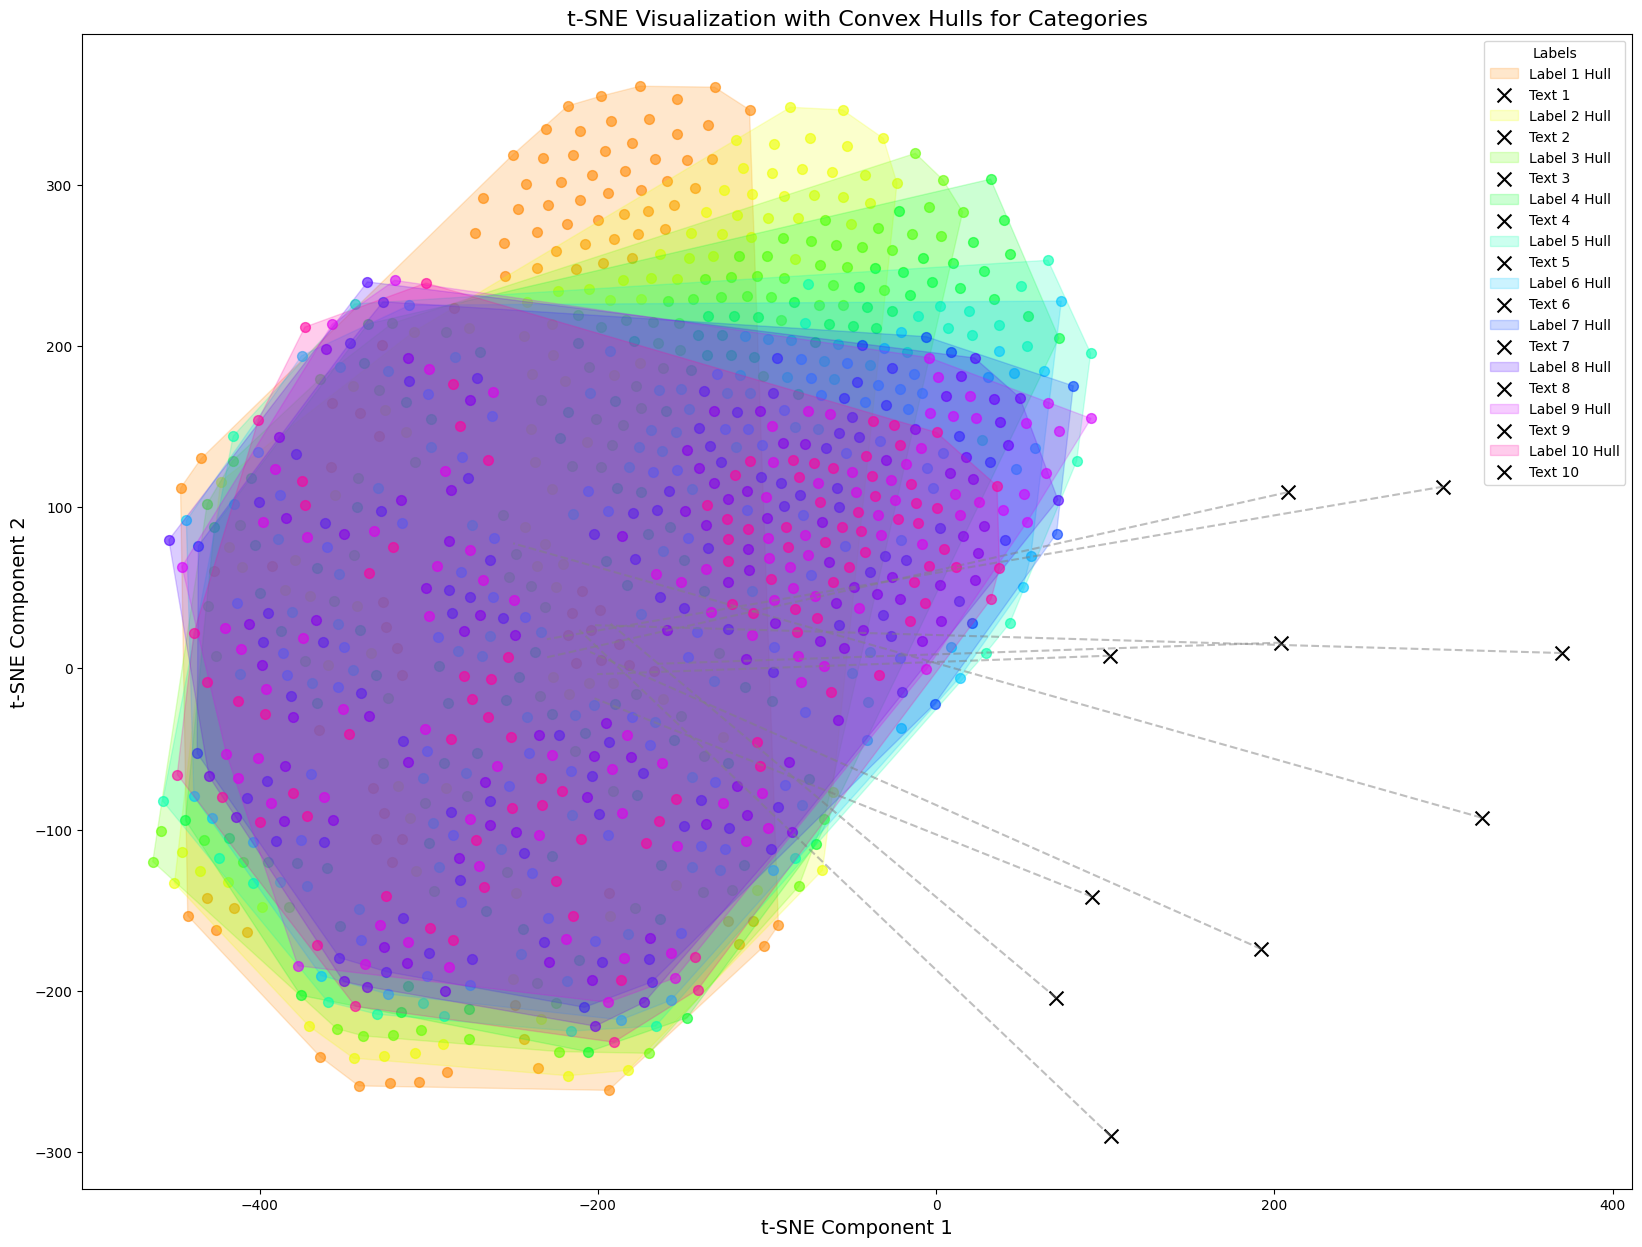

In [42]:
# Get number of images and texts
n_images = len(image_features)
n_texts = len(text_features)

# Create labels from filenames
image_labels = [int(filename.split('_')[0]) for filename in test_files]
text_labels = [int(filename.split('_')[0]) for filename in test_files]

# Get unique labels and color map
unique_labels = np.unique(image_labels)
colors = sns.color_palette("hsv", len(unique_labels))

# Create figure
plt.figure(figsize=(20, 15))

# Loop through each unique label
for idx, label in enumerate(unique_labels):
    # Get indices of images with current label
    image_indices = [i for i, img_label in enumerate(image_labels) if img_label == label]
    
    # Get the image embeddings for current label
    current_image_embeddings = embedding_tsne[image_indices]
    
    # Get the corresponding text embedding
    # Text embeddings start after all image embeddings
    text_index = n_images + text_labels.index(label)
    text_embedding = embedding_tsne[text_index]
    
    # Plot image points with their respective colors
    plt.scatter(current_image_embeddings[:, 0], 
                current_image_embeddings[:, 1], 
                c=[colors[idx]], s=50, alpha=0.6)

    # Create convex hull if we have enough points
    if len(current_image_embeddings) >= 3:
        # Calculate convex hull for the image embeddings
        hull = ConvexHull(current_image_embeddings)
        
        # Plot convex hull for the category
        plt.fill(current_image_embeddings[hull.vertices, 0], 
                 current_image_embeddings[hull.vertices, 1], 
                 color=colors[idx], alpha=0.2, 
                 label=f'Label {label} Hull')
        
        # Calculate centroid of the hull
        centroid = np.mean(current_image_embeddings[hull.vertices], axis=0)
        
        # Plot the text point for the label
        plt.scatter(text_embedding[0], text_embedding[1], 
                   c='black', marker='x', s=100, 
                   label=f'Text {label}')
        
        # Draw connection line from text to centroid
        plt.plot([text_embedding[0], centroid[0]], 
                 [text_embedding[1], centroid[1]], 
                 color='gray', linestyle='--', alpha=0.5)

# Add title and labels
plt.title('t-SNE Visualization with Convex Hulls for Categories', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Add legend
# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           loc='best', title='Labels')

plt.show()